# Understanding the Problem (Clustering of N-Intersecting lines)

1) We are given N lines that can be intersecting at k points. In other words, it is the multiple line segment challenge. <br> <br> 
2) Intital (wrong) thoughts were perhaps to attemp a computer-vision/blob detection kind of approach, but that would be computatiionally intense. <br> <br> 
3) Correct approach will be: <br> 
   a) Determine pair-wise intersections of lines (e.g., which line intersecting which line?)<br> 
   b) Construct an adjaceny matrix to represent this finite undirected graph. <br> 
   c) Clustering the adjaceny matrix to identify the number of total clusters.  <br> 
   
   <img src="ab_understand.png" alt="Drawing" style="width: 300px;"/>

In [2]:
# Python - Import all the libraries

%pylab inline
import numpy as np # a high-performance multidimensional array library
import matplotlib.pyplot as plt # for visualization
import pylab as pl 
from matplotlib import collections  as mc #
import time
import igraph as ig # for graph visualization
from scipy.sparse.csgraph import connected_components # for conneted component analysis
from scipy.sparse import csr_matrix
import networkx as nx # for graph construction

Populating the interactive namespace from numpy and matplotlib


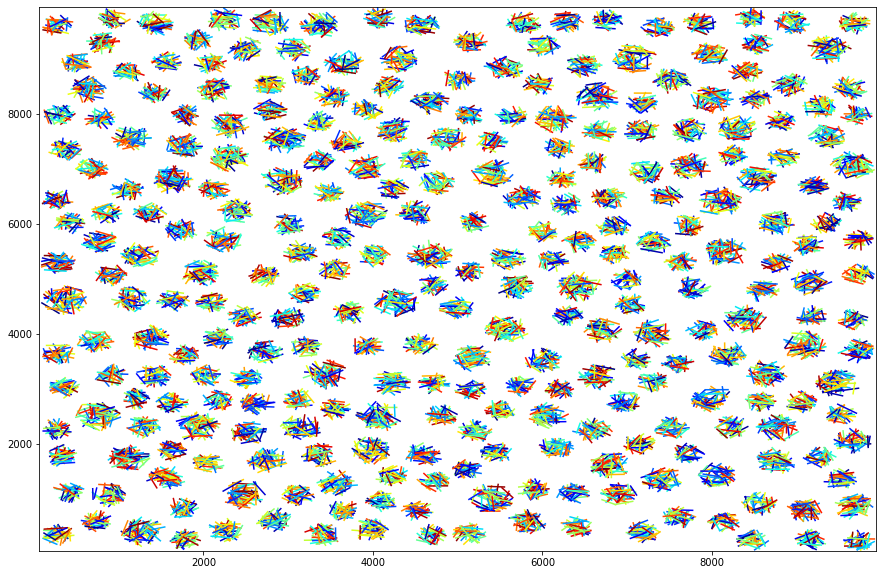

In [3]:
# Path to the text file
path_to_data = 'lines_286.txt' # Reading the Lines with 286 Clusters (For example)

def load_data(path_to_data):
    """ function to load the input data
    Input:
         path_to_data -> path to the input file
    Output:
         lines -> numpy array containing the lines data         
         number_of_lines -> total number of lines
    """
    
    lines = np.loadtxt(path_to_data)
    number_of_lines = lines.shape[0] # number of rows equal to number of unique lines

    return lines, number_of_lines # return the lines and the total number of lines. 


def plot_data(lines, plot):
    """ funtion to plot the input data (for sake of understanding)
    Input:
          lines  -> numpy array containing the lines data 
                format ~ (x1,y1,x2,y2)
    Output:
          lines_segs -> 2D list containg the lines data
               format ~ [(x1,y1),(x2,y2)]         
    """
    
    lines_segs = []
    colors = []
    my_cmap = plt.get_cmap('jet')
    for i in range(lines.shape[0]):
        x1,y1,x2,y2 = lines[i,0], lines[i,1], lines[i,2], lines[i,3]
        c  = random.random()
        colors.append(my_cmap(c))
        lines_segs.append(((x1, y1), (x2, y2)))

    ln_coll = mc.LineCollection(lines_segs, colors=colors)
    if plot:
        fig, axes = plt.subplots(figsize=(15, 10))
        axes.add_collection(ln_coll)
        axes.set_xlim(np.amin(lines), np.amax(lines))    
        axes.set_ylim(np.amin(lines), np.amax(lines))
        plt.draw()

    return lines_segs

# Load the Input Data
lines, number_of_lines = load_data(path_to_data)
# Plot the Input data
lines_segs =  plot_data(lines, plot = True)

# Understanding the Data

<b> Define Cluster</b>:  <br>

1) If two lines intersect each other, they will be part of the same cluster. <br>
2) If two lines intersect a common third line, they will be part of the same cluster. <br>

<b> Obervations</b>: <br>
1) Can visualize clearly define clusters. If one can get intersections of lines, seperating into clusters is a
comparatively easy task. <br>
2) A lot of lines and cluster, efficiency of algo will be a challenge. <br>
3) First task is to find line-line intersection. 


# Line-Line Intersection


<b> Bezier Curve:</b>
    
A linear Bezier curve can describe how far B(t) is from P0 to P1. Example given below: <br>
  
<img src="b_understand.png" alt="Drawing" style="width: 300px;"/>

<br>

We cab define L1 and L2 in terms of Bezier parameters:

<math>
 $ L_1  =  \begin{bmatrix}x_1  \\ y_1\end{bmatrix} +  t \begin{bmatrix}x_2-x_1 \\ y_2-y_1\end{bmatrix}$

<br>
    
$L_2 =   \begin{bmatrix}x_3     \\ y_3\end{bmatrix} + u \begin{bmatrix}x_4-x_3 \\ y_4-y_3\end{bmatrix}$
</math>

The lines are intersecting, if t and u are equal to:
<br>
<math>
$t = \frac{(x_1 - x_3)(y_3-y_4)-(y_1-y_3)(x_3-x_4)}{(x_1-x_2)(y_3-y_4)-(y_1-y_2)(x_3-x_4)}$
</math>
<br>
<math>
$u = \frac{(x_2 - x_1)(y_1-y_3)-(y_2-y_1)(x_1-x_3)}{(x_1-x_2)(y_3-y_4)-(y_1-y_2)(x_3-x_4)}$
</math>
<br>

The intersection will be within the L1 and L2 if 0.0&nbsp;≤&nbsp;"t"&nbsp;≤&nbsp;1.0 or 
0.0&nbsp;≤&nbsp;"u"&nbsp;≤&nbsp;1.0


In [4]:
def line_intersect(x1, y1, x2, y2, x3, y3, x4, y4):
    """ Function to calculate if two lines intersect (following the mathematics described above)
    
    Input:
        (x1, y1, x2, y2, x3, y3, x4, y4) - > L1 start and end point (x1, y1, x2, y2)
                                         - > L2 start and end point (x3, y3, x4, y4)  
    Output:
         Boolean: True  -> If the lines Intersect
                  False -> If the lines do not Intersect
    
    Ref: https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection"""
    
    d = (y4 - y3) * (x2 - x1) - (x4 - x3) * (y2 - y1)
    if d:
        t = ((x4 - x3) * (y1 - y3) - (y4 - y3) * (x1 - x3)) / d
        u = ((x2 - x1) * (y1 - y3) - (y2 - y1) * (x1 - x3)) / d
    else:
        return False 
    
    # Caclulting the point of Intersection P(x,y)
    """
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)""" # not required for the adjaceny matrix
    
    if (0 <= t <= 1 and 0 <= u <= 1):
        return True
    else:
        return False
      

In [5]:
def clock_wise(x1,y1,x2,y2,x3,y3):
    return (y3-y1) * (x2-x1) > (y2-y1) * (x3-x1)


def line_intersect_vectors(x1, y1, x2, y2, x3, y3, x4, y4):
    
    """Function to calculate the intersection of lines based on vectors
        Input:
        (x1, y1, x2, y2, x3, y3, x4, y4) - > L1 start and end point (x1, y1, x2, y2)
                                         - > L2 start and end point (x3, y3, x4, y4) 
        Output:
         Boolean: True  -> If the lines Intersect
                  False -> If the lines do not Intersect
        Considerations:
                      It wouldn't work if the lines are collinear. 
    """
    return clock_wise(x1,y1,x3,y3,x4,y4) != clock_wise(x2,y2,x3,y3,x4,y4) and clock_wise(x1,y1,x2,y2,x3,y3) != clock_wise(x1,y1,x2,y2,x4,y4)


# Multiple Lines Intersection - O(n^2) Cost

A computationally expensive way to detect multiple lines intersection is to use check each line against each 
possible other line. This use the double for loop, and would take "alot" of time if the segments are more than a few
thousands. 


In [6]:
def multiple_lines_intersection(lines):
    """ Function to calculate the intersection of multiple lines.
        Input:
              lines - > All Input Line Segments
        Output:
              adj_matrix  - > An adjaceny matrix, dimension is lines * lines. 
                            i.e, adj_matrx[L1,L2] =1 , if L1 and L2 intersect, otherwise, 0.
    
    """
    start_time = time.time()

    adj_matrix = np.zeros((number_of_lines,number_of_lines))
    for i in range(0,number_of_lines):
        for j in range(i,number_of_lines):
            adj_matrix[i,j] = line_intersect(lines[i,0],lines[i,1],lines[i,2],lines[i,3],
                                                   lines[j,0],lines[j,1],lines[j,2],lines[j,3])
        
    print("--- %s seconds ---" % (time.time() - start_time))
        
    return adj_matrix   

# Time

It takes around 160-200 seconds to run on ~10k lines, that is not preferable for practical demonstrations

--- 173.24789309501648 seconds ---
(9854, 9854)


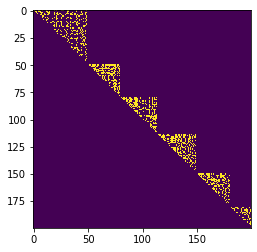

In [7]:
#Run the multiple lines adjaceny function to calcculate the adjacceny matrix
adj_matrix = multiple_lines_intersection(lines)
print(adj_matrix.shape)
plt.imshow(adj_matrix[:200,:200]) # visalize a subset of the matrix

# Visualizing the Graph 

<b>igraph library:</b> <br>
igraph consists of a set of tools that can be used to analyse networks efficiently. igraph is free available and is available for Python, R, C/C++ and Mathematica. <br>

<b>Install:</b> <br>
pip install python-igraph, pip install cairocffi <br>

We will construct an undirected graph using the adjaceny matrix. We will display the suubset of graph. 

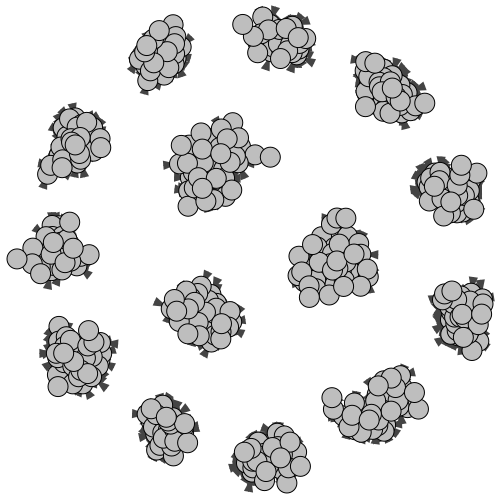

In [8]:
## Parameters for the layout of the Graph
visual_style = {}
# Define colors used for outdegree visualization
colours = ['#fecc5c', '#a31a1c']
# Set bbox and margin
visual_style["bbox"] = (500,500)
visual_style["margin"] = 17
# Set vertex colours
visual_style["vertex_color"] = 'grey'
# Set vertex size
visual_style["vertex_size"] = 20
# Set vertex lable size
visual_style["vertex_label_size"] = 8
# Don't curve the edges
visual_style["edge_curved"] = False



def vis_adj_matrix_update(adj_matrix_vis):
    """ Function calculate the igraph.Graph object.
        Input:
            adj_matrix_vis: Input adjaceny matrix
        Output:
            g: igraph object
    """
    # make sure the data type is bool 
    adj_matrix_vis = np.array(adj_matrix_vis, dtype=bool)
    g = ig.Graph.Adjacency(adj_matrix_vis.tolist())
    return g 
    

# Plot the full graph
#g = vis_adj_matrix_update (adj_matrix)
#ig.plot(g,**visual_style) 

# Plot the subset of graph
g = vis_adj_matrix_update(adj_matrix[:500,:500])
ig.plot(g,**visual_style) 

# Connected Component Analysis 


An Improved Algorithm for Finding the Strongly Connected Components of a Directed Graph by David J. Pearce Computer Science Group, Victoria University, NZ. <br>


Algorithm is an extension of the Depth First search (DFS) method. 

<b>Algorithm  DFS(V,E) -> Vertices and Edges of a graph. </b> <br>
1: index = 0 <br>
2: for all v ∈ V do visited[v] = false <br>
3: for all v ∈ V do <br>
4: if ¬visited[v] then visit(v) <br>
procedure visit(v) <br>
5: visited[v] = true ; index = index + 1 <br>
6: for all v→w ∈ E do <br> 
7: if ¬visited[w] then visit(w) <br>
    
DFS takes O(v+e) tiimes to run. It takes v(2 + 5w) bits of storage, where w is machine word size. <br>
    
On the other had, Davvid algorithm is an improvement of DFS, it takes less storage requirements, i.e.,3vw bits in the worst case. <br>

Fortunately, there is an implementation of David's algorithm in the scipy and we can use that. Please refer to the priginal paper for more details of the paper: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.102.1707&rep=rep1&type=pdf <br>

In [9]:
#Connected Component Analysis
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.connected_components.html

def connected_component_analysis(adj_matrix):
    """ Function perform the connected component analysis on the adjaceny matrix and return the number of c
    components and also individual label for each row of the adjaceny matrix
    Input:
            adj_matrix_vis: Input adjaceny matrix
        Output:
            n_components: Total number of Clusters
            labels: Label for each line segment"""
    
    #Compressed Sparse Row matrix
    graph = csr_matrix(adj_matrix) # the matrix is already sparse so not really needed. 
    n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
    print("--- Total number of components %d ---" % (n_components))
    return n_components, labels

# Run the connected component analysis
n_components, labels = connected_component_analysis(adj_matrix)

--- Total number of components 286 ---


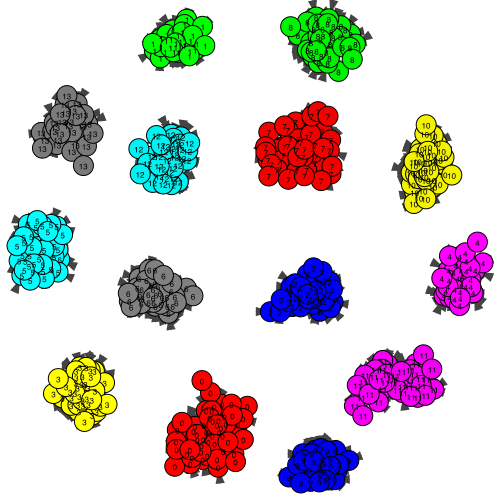

In [10]:
# Update the Style of graph to label the cluster
pal = ig.drawing.colors.ClusterColoringPalette(n_components)
visual_style["vertex_color"] = pal.get_many(labels)
visual_style["vertex_label"] = labels

# Plot the subset of graph with the labels for each line
g = vis_adj_matrix_update(adj_matrix[:500,:500])
ig.plot(g,**visual_style) 

# Faster Implementation of Multiple Lines Intersection (bentley-ottmann algorithm)

Bentley–Ottmann algorithm is a sweep line algorithm that can find all crossings in a set of line segments. The algorithm takes ${\displaystyle {\mathcal {O}}((n+k)\log n)}$ time to run, so it is much faster as compared to the pair-wise line-by-line intersection algorithm. 

<b>How it works?</b> <br>
The main idea of the Bentley–Ottmann algorithm is to use a sweep line approach, in which a vertical line L moves from left to right (or, e.g., from top to bottom) across the plane, intersecting the input line segments in sequence as it moves. <br>

 <img src="c_understand.png" alt="Drawing" style="width: 800px;"/>
 
<br> The Bentley–Ottmann performs three major steps that are detailed here: https://en.wikipedia.org/wiki/Bentley%E2%80%93Ottmann_algorithm <br>


Implementation: There exists sever implementations of Bentley–Ottmann algorithm openly available. Due to time restrictions, I took the avalable python implementation and tweaked the code as per the requirements. 

In [11]:
"""The code below for the bentley-ottmann algorithm is modified from the https://github.com/splichte/lsi
All credits goes to the original author of the algorithm"""

## Helper function for the bentley-ottmann algorithm
ev = 0.0000001
# floating-point comparison
def approx_equal(a, b, tol):
	return abs(a - b) < tol

# compares x-values of two pts
# used for ordering in T
def compare_by_x(k1, k2):
	if approx_equal(k1[0], k2[0], ev):
		return 0
	elif k1[0] < k2[0]:
		return -1
	else:
		return 1

# higher y value is "less"; if y value equal, lower x value is "less"
# used for ordering in Q
def compare_by_y(k1, k2):
	if approx_equal(k1[1], k2[1], ev):
		if approx_equal(k1[0], k2[0], ev):
			return 0
		elif k1[0] < k2[0]:
			return -1
		else:
			return 1
	elif k1[1] > k2[1]:
		return -1
	else:
		return 1

# tests if s0 and s1 represent the same segment (i.e. pts can be in 2 different orders)
def segs_equal(s0, s1):
	x00 = s0[0][0]
	y00 = s0[0][1]
	x01 = s0[1][0]
	y01 = s0[1][1]
	x10 = s1[0][0]
	y10 = s1[0][1]
	x11 = s1[1][0]
	y11 = s1[1][1]
	if (approx_equal(x00, x10, ev) and approx_equal(y00, y10, ev)):
		if (approx_equal(x01, x11, ev) and approx_equal(y01, y11, ev)):
			return True
	if (approx_equal(x00, x11, ev) and approx_equal(y00, y11, ev)):
		if (approx_equal(x01, x10, ev) and approx_equal(y01, y10, ev)):
			return True
	return False

# get m for a given seg in (p1, p2) form
def get_slope(s):
	x0 = s[0][0]
	y0 = s[0][1]
	x1 = s[1][0]
	y1 = s[1][1]
	if (x1-x0)==0:
		return None
	else:
		return float(y1-y0)/(x1-x0)

# given a point p, return the point on s that shares p's y-val
def get_x_at(s, p):
	m = get_slope(s)
	# TODO: this should check if p's x-val is octually on seg; we're assuming
	# for now that it would have been deleted already if not 
	if m == 0: # horizontal segment
		return p
	# ditto; should check if y-val on seg
	if m is None: # vertical segment
		return (s[0][0], p[1])
	x1 = s[0][0]-(s[0][1]-p[1])/m
	return (x1, p[1])

# returns the point at which two line segments intersect, or None if no intersection.
def intersect(seg1, seg2):
	p = seg1[0]
	r = (seg1[1][0]-seg1[0][0], seg1[1][1]-seg1[0][1])
	q = seg2[0]
	s = (seg2[1][0]-seg2[0][0], seg2[1][1]-seg2[0][1])
	denom = r[0]*s[1]-r[1]*s[0]
	if denom == 0:
		return None
	numer = float(q[0]-p[0])*s[1]-(q[1]-p[1])*s[0]
	t = numer/denom
	numer = float(q[0]-p[0])*r[1]-(q[1]-p[1])*r[0]
	u = numer/denom
	if (t < 0 or t > 1) or (u < 0 or u > 1):
		return None
	x = p[0]+t*r[0]
	y = p[1]+t*r[1]
	return (x, y)


""" Priority Queue Class: It is used to maintain a sequence of potential future events in
    the Bentley–Ottmann algorithm.
"""

class Q:
	def __init__(self, key, value):
		self.key = key
		self.value = value
		self.left = None
		self.right = None
	
	def find(self, key):
		if self.key is None:
			return False
		c = compare_by_y(key, self.key)
		if c==0:
			return True
		elif c==-1:
			if self.left:
				self.left.find(key)
			else:
				return False
		else:
			if self.right:
				self.right.find(key)
			else:
				return False
	def insert(self, key, value):
		if self.key is None:
			self.key = key
			self.value = value
		c = compare_by_y(key, self.key)
		if c==0:
			self.value += value
		elif c==-1:
			if self.left is None:
				self.left = Q(key, value)
			else:
				self.left.insert(key, value)
		else:
			if self.right is None:
				self.right = Q(key, value)
			else:
				self.right.insert(key, value)
	# must return key AND value
	def get_and_del_min(self, parent=None):
		if self.left is not None:
			return self.left.get_and_del_min(self)
		else:
			k = self.key
			v = self.value
			if parent:
				parent.left = self.right
			# i.e. is root node
			else:
				if self.right:
					self.key = self.right.key
					self.value = self.right.value
					self.left = self.right.left
					self.right = self.right.right
				else:
					self.key = None
			return k,v
 
""" Binary Search Tree Class       
    We have a sweep line, L, A binary search tree containS the set of input line segments that cross L, 
    ordered by the y-coordinates of the points where these segments cross L"""

class T:
	def __init__(self):
		self.root = Node(None, None, None, None)
	def contain_p(self, p):
		if self.root.value is None:
			return [[], []]
		lists = [[], []]
		self.root.contain_p(p, lists) 
		return (lists[0], lists[1])
	def get_left_neighbor(self, p):
		if self.root.value is None:
			return None
		return self.root.get_left_neighbor(p)
	def get_right_neighbor(self, p):
		if self.root.value is None:
			return None
		return self.root.get_right_neighbor(p)
	def insert(self, key, s):
		if self.root.value is None:
			self.root.left = Node(s, None, None, self.root)
			self.root.value = s 
			self.root.m = get_slope(s)
		else:
			(node, path) = self.root.find_insert_pt(key, s)
			if path == 'r':
				node.right = Node(s, None, None, node)
				node.right.adjust()
			elif path == 'l':
				node.left = Node(s, None, None, node)
			else:
				# this means matching Node was a leaf
				# need to make a new internal Node
				if node.compare_to_key(key) < 0 or (node.compare_to_key(key)==0 and node.compare_lower(key, s) < 1):
					new_internal = Node(s, None, node, node.parent)
					new_leaf = Node(s, None, None, new_internal)
					new_internal.left = new_leaf
					if node is node.parent.left:
						node.parent.left = new_internal
						node.adjust()
					else:
						node.parent.right = new_internal
				else:
					new_internal = Node(node.value, node, None, node.parent)
					new_leaf = Node(s, None, None, new_internal)
					new_internal.right = new_leaf
					if node is node.parent.left:
						node.parent.left = new_internal
						new_leaf.adjust()
					else:
						node.parent.right = new_internal
				node.parent = new_internal

	def delete(self, p, s):
		key = p
		node = self.root.find_delete_pt(key, s)
		val = node.value
		if node is node.parent.left:
			parent = node.parent.parent
			if parent is None:
				if self.root.right is not None:
					if self.root.right.left or self.root.right.right:
						self.root = self.root.right
						self.root.parent = None
					else:
						self.root.left = self.root.right
						self.root.value = self.root.right.value
						self.root.m = self.root.right.m
						self.root.right = None
				else:
					self.root.left = None
					self.root.value = None
			elif node.parent is parent.left:
				parent.left = node.parent.right
				node.parent.right.parent = parent
			else:
				parent.right = node.parent.right
				node.parent.right.parent = parent
		else:
			parent = node.parent.parent
			if parent is None:
				if self.root.left:
					# switch properties
					if self.root.left.right or self.root.left.left:
						self.root = self.root.left
						self.root.parent = None
					else:
						self.root.right = None
				else:
					self.root.right = None
					self.root.value = None
			elif node.parent is parent.left:
				parent.left = node.parent.left
				node.parent.left.parent = parent
				farright = node.parent.left
				while farright.right is not None:
					farright = farright.right
				farright.adjust()
			else:
				parent.right = node.parent.left
				node.parent.left.parent = parent
				farright = node.parent.left
				while farright.right is not None:
					farright = farright.right
				farright.adjust()
		return val

	def print_tree(self):
		self.root.print_tree()
class Node:
	def __init__(self, value, left, right, parent):
		self.value = value # associated line segment 
		self.left = left
		self.right = right
		self.parent = parent
		self.m = None
		if value is not None:
			self.m = get_slope(value)

	# compares line segment at y-val of p to p 
	# TODO: remove this and replace with get_x_at
	def compare_to_key(self, p):
		x0 = self.value[0][0]
		y0 = self.value[0][1]
		y1 = p[1]
		if self.m != 0 and self.m is not None:
			x1 = x0 - float(y0-y1)/self.m
			return compare_by_x(p, (x1, y1))
		else:
			x1 = p[0]
			return 0 
	
	def get_left_neighbor(self, p):
		neighbor = None
		n = self
		if n.left is None and n.right is None:
			return neighbor
		last_right = None
		found = False
		while not found:
			c = n.compare_to_key(p)
			if c < 1 and n.left:
				n = n.left
			elif c==1 and n.right:
				n = n.right
				last_right = n.parent
			else:
				found = True
		c = n.compare_to_key(p)
		if c==0:
			if n is n.parent.right:
				return n.parent
			else:
				goright = None
				if last_right:
					goright =last_right.left
				return self.get_lr(None, goright)[0]
		# n stores the highest-value in the left subtree
		if c==-1:
			goright = None
			if last_right:
				goright = last_right.left
			return self.get_lr(None, goright)[0]
		if c==1:
			neighbor = n
		return neighbor

	def get_right_neighbor(self, p):
		neighbor = None
		n = self
		if n.left is None and n.right is None:
			return neighbor
		last_left = None
		found = False
		while not found:
			c = n.compare_to_key(p)
			if c==0 and n.right:
				n = n.right
			elif c < 0 and n.left:
				n = n.left
				last_left = n.parent
			elif c==1 and n.right:
				n = n.right
			else:
				found = True
		c = n.compare_to_key(p)
		# can be c==0 and n.left if at root node
		if c==0:
			if n.parent is None:
				return None
			if n is n.parent.right:
				goleft = None
				if last_left:
					goleft = last_left.right
				return self.get_lr(goleft, None)[1]
			else:
				return self.get_lr(n.parent.right, None)[1]
		if c==1:
			goleft = None
			if last_left:
				goleft = last_left.right
			return self.get_lr(goleft, None)[1]
		if c==-1:
			return n
		return neighbor

	# travels down a single direction to get neighbors
	def get_lr(self, left, right):
		lr = [None, None]
		if left:
			while left.left:
				left = left.left
			lr[1] = left
		if right:
			while right.right:
				right = right.right
			lr[0] = right
		return lr
	
	def contain_p(self, p, lists):
		c = self.compare_to_key(p)
		if c==0:
			if self.left is None and self.right is None:
				if compare_by_x(p, self.value[1])==0:
					lists[1].append(self.value)
				else:
					lists[0].append(self.value)	
			if self.left:
				self.left.contain_p(p, lists)
			if self.right:
				self.right.contain_p(p, lists)
		elif c < 0:
			if self.left:
				self.left.contain_p(p, lists)
		else:
			if self.right:
				self.right.contain_p(p, lists)

	def find_insert_pt(self, key, seg):
		if self.left and self.right:
			if self.compare_to_key(key) == 0 and self.compare_lower(key, seg)==1:
				return self.right.find_insert_pt(key, seg)
			elif self.compare_to_key(key) < 1:
				return self.left.find_insert_pt(key, seg)
			else:
				return self.right.find_insert_pt(key, seg)	
		# this case only happens at root
		elif self.left:
			if self.compare_to_key(key) == 0 and self.compare_lower(key, seg)==1:
				return (self, 'r')
			elif self.compare_to_key(key) < 1:
				return self.left.find_insert_pt(key, seg)
			else:
				return (self, 'r')
		else:
			return (self, 'n')

	# adjusts stored segments in inner nodes
	def adjust(self):
		value = self.value
		m = self.m
		parent = self.parent
		node = self
		# go up left as much as possible
		while parent and node is parent.right:
			node = parent
			parent = node.parent
		# parent to adjust will be on the immediate right
		if parent and node is parent.left:
			parent.value = value
			parent.m = m
	
	def compare_lower(self, p, s2):
		y = p[1] - 10
		key = get_x_at(s2, (p[0], y))
		return self.compare_to_key(key)

	# returns matching leaf node, or None if no match
	# when deleting, you don't delete below--you delete above! so compare lower = -1.
	def find_delete_pt(self, key, value):
		if self.left and self.right:
			# if equal at this pt, and this node's value is less than the seg's slightly above this pt
			if self.compare_to_key(key) == 0 and self.compare_lower(key, value)==-1:
				return self.right.find_delete_pt(key, value)
			if self.compare_to_key(key) < 1:
				return self.left.find_delete_pt(key, value)
			else:
				return self.right.find_delete_pt(key, value)
		elif self.left:
			if self.compare_to_key(key) < 1:
				return self.left.find_delete_pt(key, value)
			else:
				return None
		# is leaf
		else:
			if self.compare_to_key(key)==0 and segs_equal(self.value, value):
				return self
			else:
				return None 
            
# how much lower to get the x of a segment, to determine which of a set of segments is the farthest right/left
lower_check = 100

# gets the point on a segment at a lower y value.
def getNextPoint(p, seg, y_lower):
	p1 = seg[0]
	p2 = seg[1]
	if (p1[0]-p2[0])==0:
		return (p[0]+10, p[1])
	slope = float(p1[1]-p2[1])/(p1[0]-p2[0])
	if slope==0:
		return (p1[0], p[1]-y_lower)
	y = p[1]-y_lower
	x = p1[0]-(p1[1]-y)/slope
	return (x, y)

"""
for each event point:
	U_p = segments that have p as an upper endpoint
	C_p = segments that contain p
	L_p = segments that have p as a lower endpoint
"""
def handle_event_point(p, segs, q, t, intersections):
	rightmost = (float("-inf"), 0)
	rightmost_seg = None
	leftmost = (float("inf"), 0) 
	leftmost_seg = None

	U_p = segs
	(C_p, L_p) = t.contain_p(p)
	merge_all = U_p+C_p+L_p
	if len(merge_all) > 1:
		intersections[p] = []
		for s in merge_all:
			intersections[p].append(s) 
	merge_CL = C_p+L_p
	merge_UC = U_p+C_p
	for s in merge_CL:
		# deletes at a point slightly above (to break ties) - where seg is located in tree
		# above intersection point
		t.delete(p, s)
	# put segments into T based on where they are at y-val just below p[1]
	for s in merge_UC:
		n = getNextPoint(p, s, lower_check) 
		if n[0] > rightmost[0]:
			rightmost = n 
			rightmost_seg = s
		if n[0] < leftmost[0]:
			leftmost = n
			leftmost_seg = s
		t.insert(p, s)

	# means only L_p -> check newly-neighbored segments
	if len(merge_UC) == 0:
		neighbors = (t.get_left_neighbor(p), t.get_right_neighbor(p))
		if neighbors[0] and neighbors[1]:
			find_new_event(neighbors[0].value, neighbors[1].value, p, q)
			
	# of newly inserted pts, find possible intersections to left and right
	else:
		left_neighbor = t.get_left_neighbor(p)
		if left_neighbor:
			find_new_event(left_neighbor.value, leftmost_seg, p, q)
		right_neighbor = t.get_right_neighbor(p)
		if right_neighbor:
			find_new_event(right_neighbor.value, rightmost_seg, p, q)

def find_new_event(s1, s2, p, q):
	i = intersect(s1, s2)
	if i:
		if compare_by_y(i, p) == 1:
			if not q.find(i):
				q.insert(i, [])
	
# segment is in ((x, y), (x, y)) form
# first pt in a segment should have higher y-val - this is handled in function
def intersection_bo_algorithm(S):
	s0 = S[0]
	if s0[1][1] > s0[0][1]:
		s0 = (s0[1], s0[0])
	q = Q(s0[0], [s0])
	q.insert(s0[1], [])
	intersections = {}
	for s in S[1:]:
		if s[1][1] > s[0][1]:
			s = (s[1], s[0])
		q.insert(s[0], [s])
		q.insert(s[1], [])
	t = T()
	while q.key:
		p, segs = q.get_and_del_min()
		handle_event_point(p, segs, q, t, intersections)
	return intersections            

# Apply the bentley-ottmann algorithm.

Apply the bentley-ottmann algorithm for the 286 components class and compare how it improves the performance. <br>

It is 7-8 times faster for this data-set as compare to the crude approach. 


In [12]:
# Load the Input Data (any input file can be given here)
path_to_data = 'lines_286.txt'
lines, number_of_lines = load_data(path_to_data)
# Plot the Input data (and convert to list format)
lines_segs =  plot_data(lines, plot = False)

# Run the bentley-ottmann algorithm
start_time = time.time()

# intersections_dict is a dictionary of intersection points (keys) and a list of their associated segments (values).
intersections_dict = intersection_bo_algorithm(lines_segs)
print("--- %s seconds ---" % (time.time() - start_time))

--- 22.39476180076599 seconds ---


# Networkx library in python

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. <br>

We will use the edges estimated from the bentley-ottmann algorithm, and construct a graph using Networkx library.

In [44]:
#Create an empty graph with no nodes and no edges
network_graph = nx.Graph()

# Add all the segmented lines estimated by the bentley-ottmann algorithm.
network_graph.add_edges_from(list(intersections_dict.values()))

# Visualize the graph
#nx.draw(G,node_color='b',node_size=1)

# Construct the adjaceny matrix from the graph
adj_matrix = nx.linalg.graphmatrix.adjacency_matrix(network_graph)
adj_matrix = adj_matrix.todense()

# Run the connected component analysis
n_components, labels = connected_component_analysis(adj_matrix)

--- Total number of components 286 ---


# Final Comments:


Even the bentley-ottmann is quite slow on the "lines_840.txt" file with almost ~100k lines. This made me think whether there is a better way to solve this problem? 

If the eventual goal is to find clusters, and we have a set of L lines, then we need to find k balls of minimum radius that fits the L lines. We can start with 1 ball of radius x, and increase/decrease the radius until no end points of line cross the boundary of ball, and there is atleast one line within the ball. We can fit bounding balls to the lines instead of finding the actual intersections.  

If there is a simple way of doing it, then I am surely missing the trick :-).

Total time spent - 6 hours.